# CONNECT & EXTRACT DATA FROM SQL SERVER

In [1]:
import pypyodbc as odbc #!pip install pypyodbc
import pandas as pd
import numpy as np
import time
import os

print(odbc.drivers())

['SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'SQL Server Native Client RDA 11.0']


In [2]:
driverName = "SQL Server" 
serverName = "DESKTOP-UVMKETP\SQLEXPRESS"
dataBaseName = "SQL_PowerBI_Test"
username = "jvenncpe"
pwd = "#Juv1994*"

dv = "------------------------------"

In [3]:
def updateSQL():
    try:
        conn.commit()
        return print("SQL Updated Successfully!")
        
    except Exception as e:
        return print(f"Error occurred: {e}")

In [4]:
def createFreightQuery():
    freight_query = f"""
    WITH
        CLEAN_products_category_items AS
        (
        SELECT 
            REPLACE(t1.product_id,'"','') AS product_id
            , t1.product_height_cm
            , t1.product_length_cm
            , t1.product_weight_g
            , t1.product_width_cm
            , t3.freight_value
            , t3.price
            , t3.[ï»¿order_id]
        FROM
            SQL_PowerBI_Test.dbo.olist_products_dataset AS t1
        
        LEFT JOIN [product_category_name_translation] AS t2 ON t1.product_category_name = t2.[ï»¿product_category_name]
        LEFT JOIN [olist_order_items_dataset] AS t3 ON t1.product_id = t3.product_id
        ),
        
        CLEAN_orders_customers_dataset AS
        (
        SELECT
            t1.[order_id]
            , t1.[customer_id]
            , t2.customer_city
            , t2.customer_state
            , t2.customer_zip_code_prefix
        FROM [SQL_PowerBI_Test].[dbo].[olist_orders_dataset] as t1
        
        LEFT JOIN [olist_customers_dataset] AS t2 ON t1.customer_id = t2.customer_id
        ),
        
        Distinct_CLEAN_products_category_items AS
        (
        SELECT DISTINCT *
        FROM CLEAN_products_category_items
        ),
        
        Distinct_CLEAN_orders_customers_dataset AS
        (
        SELECT DISTINCT *
        FROM CLEAN_orders_customers_dataset
        ),
        
        MERGE_allNeeded AS
        (
        SELECT
            *
        FROM Distinct_CLEAN_products_category_items AS t1
        LEFT JOIN Distinct_CLEAN_orders_customers_dataset AS t2 ON t1.[ï»¿order_id] = t2.order_id
        )
        
        SELECT DISTINCT * FROM MERGE_allNeeded WHERE freight_value IS NOT NULL
    """
    return freight_query

### SQL CONNECTION STRING

In [5]:
connection_string = f"""
    DRIVER={{{driverName}}};
    SERVER={serverName};
    DATABASE={dataBaseName};
    Trust_Connection=yes;
    UID={username};
    PWD={pwd};
"""
try:
    conn = odbc.connect(connection_string)
    cursor = conn.cursor()
    print("Connection successful!")

except Exception as e:
    print(f"Error: {e}")

Connection successful!


In [6]:
cursor = conn.cursor()

try:
    with cursor:
        cursor.execute(createFreightQuery())
        freight_query = cursor.fetchall()
except Exception as e:
    print(e)
    conn.rollback()
    print('Transaction rollback')
finally:
    if conn is not None:
        conn.close()

# DATA EXPLORATION, CLEANING & VALIDATION

### DATA EXPLORATION

In [7]:
df_freight = pd.DataFrame(freight_query)
display(df_freight)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,a000c3bbcabfea20a59fc2a10b9a6cf5,13,70,350,12,11.86\r,10,f2f5bdd435d706928f8210b650cd33bd,f2f5bdd435d706928f8210b650cd33bd,b74cd76f4d7ad4dec2b3132d50590d3b,sao paulo,SP,5036
1,a0045b8457877b5981ed6c79b9b0765a,4,19,100,11,16.79\r,19.9,e126a4c926bda89ae444a788cb74d989,e126a4c926bda89ae444a788cb74d989,bb85c4ac0d64b224ec32224e91af4980,sapeacu,BA,44530
2,a0045b8457877b5981ed6c79b9b0765a,4,19,100,11,21.15\r,19.9,84e18f4b5b541150af97e94f3cc0b2a7,84e18f4b5b541150af97e94f3cc0b2a7,b9e8d20467df2fd1b1ca8bb650a87dcc,sao luis,MA,65075
3,a0045b8457877b5981ed6c79b9b0765a,4,19,100,11,7.78\r,19.9,e0519f85bba56ba4bd2ec14a3c2c9d92,e0519f85bba56ba4bd2ec14a3c2c9d92,11fea740df095db33a9ced60fc8dd2d1,campinas,SP,13092
4,a00722035cea70bbf671b758459cde42,95,16,15742,33,53.11\r,189,0159c6355a4e32f6ac68d838e2228150,0159c6355a4e32f6ac68d838e2228150,bf0176bae5facd261148fb881ccb8cc6,santana de parnaiba,SP,6506
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38201,fffdb2d0ec8d6a61f0a0a0db3f25b441,4,16,150,13,18.23\r,34.99,beaf95465b542dea76df78b2fb86a97a,beaf95465b542dea76df78b2fb86a97a,d14930bf3da4e0ba5a02cc8d6ac80f6e,coromandel,MG,38550
38202,fffdb2d0ec8d6a61f0a0a0db3f25b441,4,16,150,13,7.39\r,34.99,dd38c566a34ff9deb93ff05d7bd6d0aa,dd38c566a34ff9deb93ff05d7bd6d0aa,35e8f2cff4eeed925cfa42f6731a4425,sao paulo,SP,3820
38203,fffdb2d0ec8d6a61f0a0a0db3f25b441,4,16,150,13,7.51\r,34.99,2878b4e373a9556df9aa1708a4e5c3c8,2878b4e373a9556df9aa1708a4e5c3c8,a050cd2edce49d430222e6019fa50fd2,sao paulo,SP,5591
38204,fffdb2d0ec8d6a61f0a0a0db3f25b441,4,16,150,13,7.51\r,34.99,d6c1ed12e8eeaa15e9d5c83c79598f85,d6c1ed12e8eeaa15e9d5c83c79598f85,550ccac77275f9cdec4b6cd97ac118d0,sao paulo,SP,4547


### COLUMN NAME CLEANING & REPLACEMENT

In [8]:
replace_columnNames = \
["Product Id",
"Product Height (cm)",
"Product Length (cm)",
"Product Weight (g)",
"Product Width (cm)",
"Freight Value",
"Price ($)",
"Order ID",
"Order ID",
"Customer ID",
"Customer City",
"Customer State",
"Customer Zip Code Prefix"]

df_freight.columns = replace_columnNames
df_freight.columns

Index(['Product Id', 'Product Height (cm)', 'Product Length (cm)',
       'Product Weight (g)', 'Product Width (cm)', 'Freight Value',
       'Price ($)', 'Order ID', 'Order ID', 'Customer ID', 'Customer City',
       'Customer State', 'Customer Zip Code Prefix'],
      dtype='object')

### CHECKING OF NULL VALUES & DROPPING OF DUPLICATE/UNRELEVANT COLUMNS

In [9]:
df_freight.isnull().sum()

Product Id                  0
Product Height (cm)         0
Product Length (cm)         0
Product Weight (g)          0
Product Width (cm)          0
Freight Value               0
Price ($)                   0
Order ID                    0
Order ID                    0
Customer ID                 0
Customer City               0
Customer State              0
Customer Zip Code Prefix    0
dtype: int64

In [10]:
df_freight_columndrop = df_freight.drop(columns = \
["Product Id",
"Order ID",
"Order ID",
"Customer ID"])

### DATA TYPE EXPLORATION AND VALIDATION

In [11]:
df_freight_columndrop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38206 entries, 0 to 38205
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Product Height (cm)       38206 non-null  object
 1   Product Length (cm)       38206 non-null  object
 2   Product Weight (g)        38206 non-null  object
 3   Product Width (cm)        38206 non-null  object
 4   Freight Value             38206 non-null  object
 5   Price ($)                 38206 non-null  object
 6   Customer City             38206 non-null  object
 7   Customer State            38206 non-null  object
 8   Customer Zip Code Prefix  38206 non-null  object
dtypes: object(9)
memory usage: 2.6+ MB


In [12]:
df_freight_columndrop.columns

Index(['Product Height (cm)', 'Product Length (cm)', 'Product Weight (g)',
       'Product Width (cm)', 'Freight Value', 'Price ($)', 'Customer City',
       'Customer State', 'Customer Zip Code Prefix'],
      dtype='object')

In [13]:
numeric_columns = ['Product Height (cm)', 'Product Length (cm)', 'Product Weight (g)',
       'Product Width (cm)', 'Freight Value', 'Price ($)']

In [14]:
print(f"New Column Data Type")
print(dv)
for column in numeric_columns:
    df_freight_columndrop[column] = pd.to_numeric(df_freight_columndrop[column], errors='coerce')
    print(f"{column}: {df_freight_columndrop[column].dtypes}")

New Column Data Type
------------------------------
Product Height (cm): int64
Product Length (cm): int64
Product Weight (g): int64
Product Width (cm): int64
Freight Value: float64
Price ($): float64


In [15]:
df_freight_columndrop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38206 entries, 0 to 38205
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Product Height (cm)       38206 non-null  int64  
 1   Product Length (cm)       38206 non-null  int64  
 2   Product Weight (g)        38206 non-null  int64  
 3   Product Width (cm)        38206 non-null  int64  
 4   Freight Value             38206 non-null  float64
 5   Price ($)                 38206 non-null  float64
 6   Customer City             38206 non-null  object 
 7   Customer State            38206 non-null  object 
 8   Customer Zip Code Prefix  38206 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 2.6+ MB


### DATA CATEGORICAL ENCODING

In [16]:
df_freight_columndrop.head(5)

,Product Height (cm),Product Length (cm),Product Weight (g),Product Width (cm),Freight Value,Price ($),Customer City,Customer State,Customer Zip Code Prefix
0,13,70,350,12,11.86,10.0,sao paulo,SP,5036
1,4,19,100,11,16.79,19.9,sapeacu,BA,44530
2,4,19,100,11,21.15,19.9,sao luis,MA,65075
3,4,19,100,11,7.78,19.9,campinas,SP,13092
4,95,16,15742,33,53.11,189.0,santana de parnaiba,SP,6506


In [17]:
# Separate columns by data type
numeric_columns = df_freight_columndrop.select_dtypes(include=['int64', 'float64'])
object_columns = df_freight_columndrop.select_dtypes(include=['object'])

In [18]:
# Mean Encoding
target_mean_customercity = df_freight_columndrop.groupby('Customer City')['Freight Value'].mean().to_dict()
target_mean_customerstate = df_freight_columndrop.groupby('Customer State')['Freight Value'].mean().to_dict()
target_mean_customerzip = df_freight_columndrop.groupby('Customer Zip Code Prefix')['Freight Value'].mean().to_dict()

In [19]:
df_freight_columndrop['Customer City'] = df_freight_columndrop['Customer City'].map(target_mean_customercity)
df_freight_columndrop['Customer State'] = df_freight_columndrop['Customer State'].map(target_mean_customerstate)
df_freight_columndrop['Customer Zip Code Prefix'] = df_freight_columndrop['Customer Zip Code Prefix'].map(target_mean_customerzip)

In [20]:
df_freight_columndrop.head(5)

,Product Height (cm),Product Length (cm),Product Weight (g),Product Width (cm),Freight Value,Price ($),Customer City,Customer State,Customer Zip Code Prefix
0,13,70,350,12,11.86,10.0,14.408382,15.333367,17.837143
1,4,19,100,11,16.79,19.9,16.790000,26.662475,16.790000
2,4,19,100,11,21.15,19.9,32.244552,38.006376,33.485833
3,4,19,100,11,7.78,19.9,14.696241,15.333367,9.770625
4,95,16,15742,33,53.11,189.0,14.301646,15.333367,53.110000


### DATA DISTRIBUTION - Violin Plot, QQ Plot, KDE Plot

#### Violin Plot

In [21]:
df_freight_columndrop.describe().round(2)

,Product Height (cm),Product Length (cm),Product Weight (g),Product Width (cm),Freight Value,Price ($),Customer City,Customer State,Customer Zip Code Prefix
count,38206.00,38206.00,38206.00,38206.00,38206.00,38206.00,38206.00,38206.00,38206.00
mean,16.32,30.23,2158.74,22.81,20.24,127.95,20.24,20.24,20.24
std,13.56,16.09,3838.24,11.68,15.96,190.79,7.80,5.73,10.35
min,2.00,11.00,0.00,6.00,0.00,3.54,0.00,15.33,0.00
25%,8.00,18.00,300.00,15.00,13.13,41.90,14.59,15.33,14.58
50%,13.00,25.00,700.00,20.00,16.33,78.00,19.10,20.68,17.98
75%,20.00,38.00,2050.00,30.00,21.30,140.00,21.89,22.14,22.66
max,105.00,105.00,30000.00,118.00,409.68,4799.00,193.84,48.77,267.08


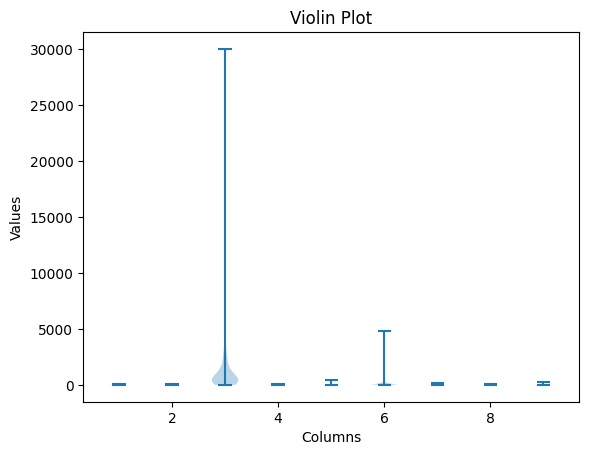

In [22]:
import matplotlib.pyplot as plt

plt.violinplot(df_freight_columndrop.values)
plt.title('Violin Plot')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

#### Q-Q & KDE Plots: "df_freight_columndrop['Freight Value']"

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


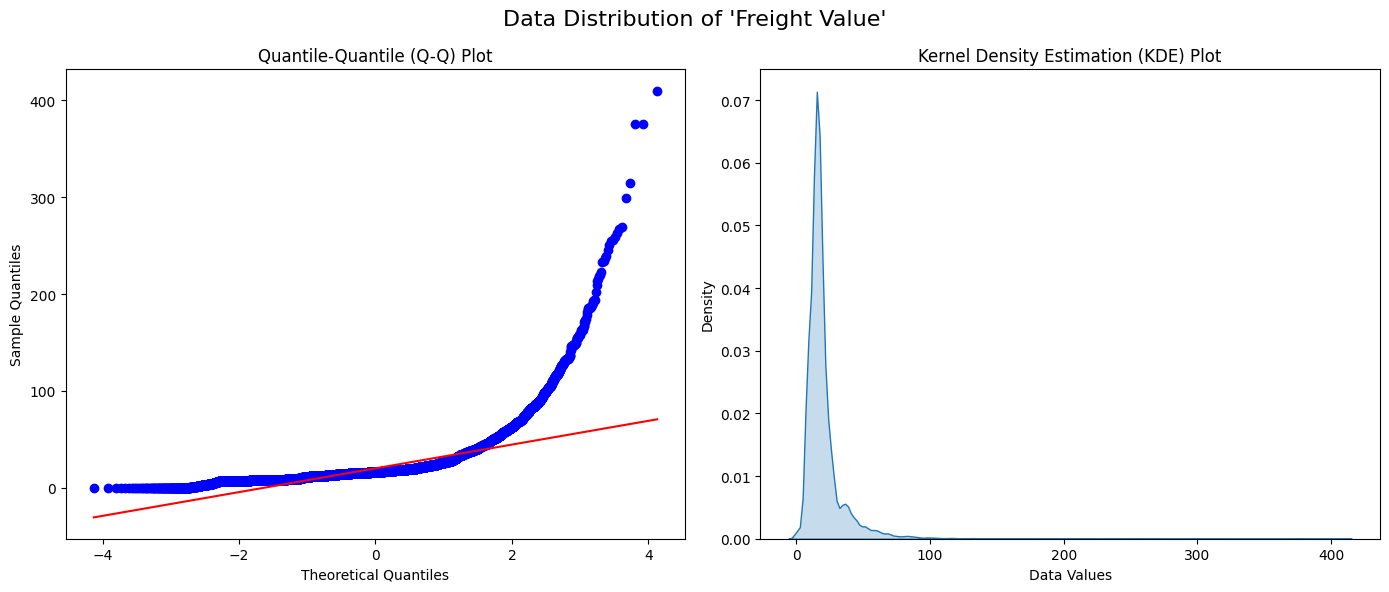

In [26]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
plt.suptitle("Data Distribution of 'Freight Value'", fontsize=16)

# Create Q-Q plot
plt.subplot(1, 2, 1)
stats.probplot(df_freight_columndrop['Freight Value'], dist="norm", plot=plt)
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Create KDE plot
plt.subplot(1, 2, 2)
sns.kdeplot(df_freight_columndrop['Freight Value'], fill=True)
plt.title('Kernel Density Estimation (KDE) Plot')
plt.xlabel('Data Values')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### DATA PRE-PROCESSING - Robust Scaler, Max ABSS Scaler & Quantile Transformation

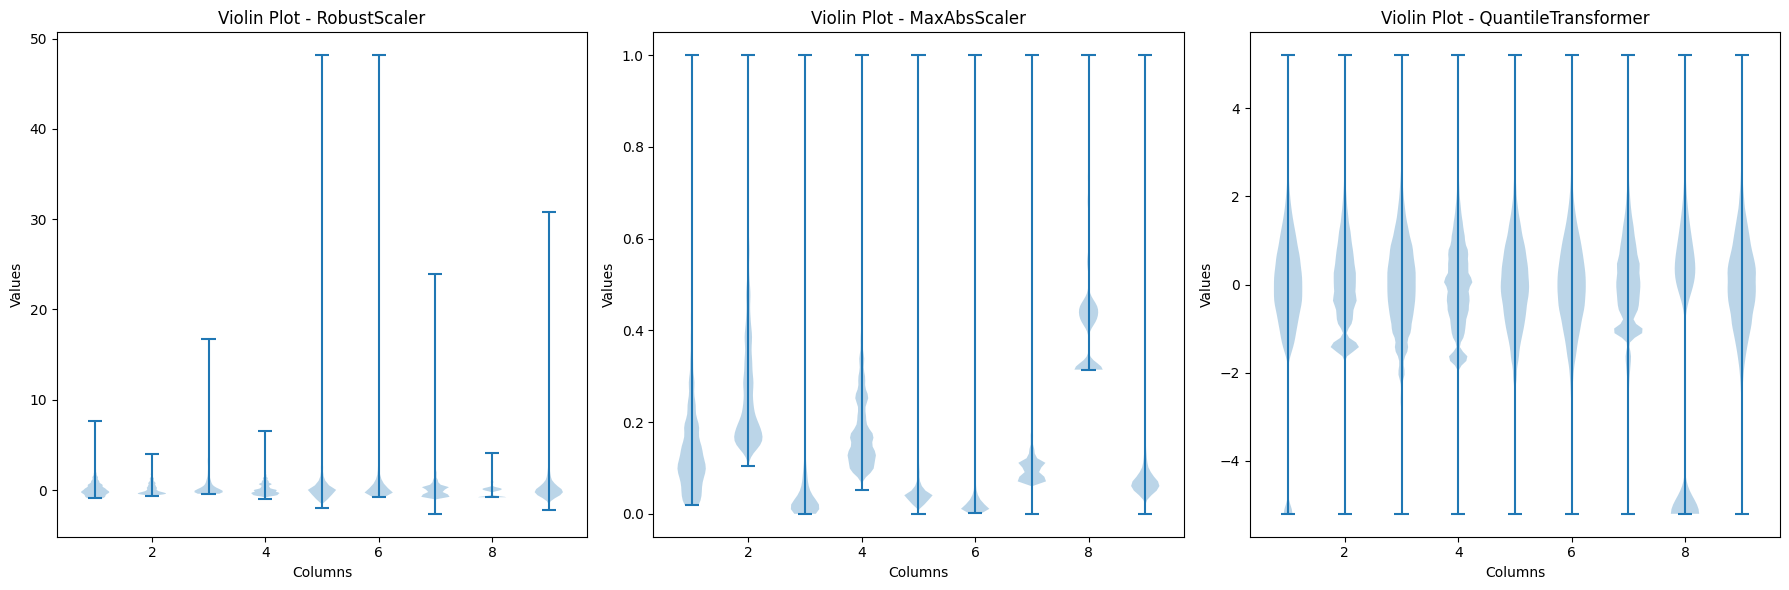

In [25]:
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, QuantileTransformer
import matplotlib.pyplot as plt

# RobustScaler
r_scaler = RobustScaler()
r_scaled_data = r_scaler.fit_transform(df_freight_columndrop)

# MaxAbsScaler
m_scaler = MaxAbsScaler()
m_scaled_data = m_scaler.fit_transform(df_freight_columndrop)

# QuantileTransformer
q_scaler = QuantileTransformer(output_distribution='normal')
q_scaled_data = q_scaler.fit_transform(df_freight_columndrop)

# Plot side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# RobustScaler Violin Plot
axs[0].violinplot(r_scaled_data)
axs[0].set_title('Violin Plot - RobustScaler')
axs[0].set_xlabel('Columns')
axs[0].set_ylabel('Values')

# MaxAbsScaler Violin Plot
axs[1].violinplot(m_scaled_data)
axs[1].set_title('Violin Plot - MaxAbsScaler')
axs[1].set_xlabel('Columns')
axs[1].set_ylabel('Values')

# QuantileTransformer Violin Plot
axs[2].violinplot(q_scaled_data)
axs[2].set_title('Violin Plot - QuantileTransformer')
axs[2].set_xlabel('Columns')
axs[2].set_ylabel('Values')

plt.tight_layout()
plt.show()


#### RobustScaler QQ & KDE Plot 

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


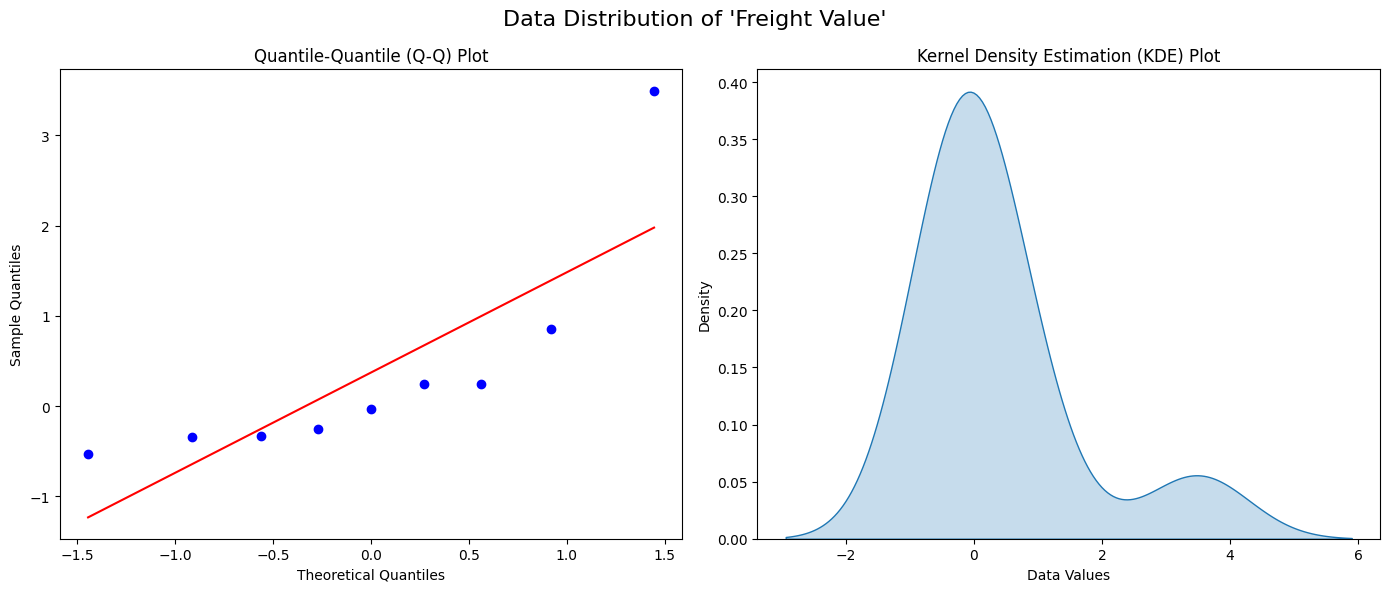

In [32]:
plt.figure(figsize=(14, 6))
plt.suptitle("Data Distribution of 'Freight Value'", fontsize=16)

# Create Q-Q plot
plt.subplot(1, 2, 1)
stats.probplot(r_scaled_data[5], dist="norm", plot=plt)
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Create KDE plot
plt.subplot(1, 2, 2)
sns.kdeplot(r_scaled_data[5], fill=True)
plt.title('Kernel Density Estimation (KDE) Plot')
plt.xlabel('Data Values')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### MaxAbsScaler QQ & KDE Plot 

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


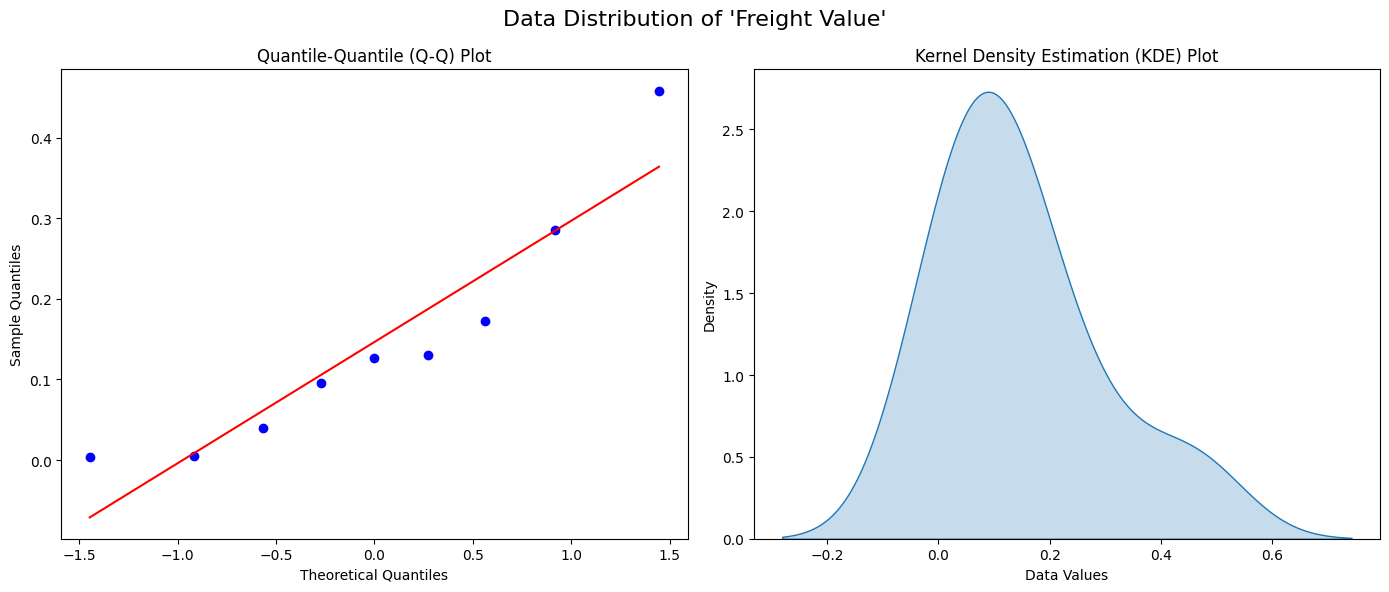

In [33]:
plt.figure(figsize=(14, 6))
plt.suptitle("Data Distribution of 'Freight Value'", fontsize=16)

# Create Q-Q plot
plt.subplot(1, 2, 1)
stats.probplot(m_scaled_data[5], dist="norm", plot=plt)
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Create KDE plot
plt.subplot(1, 2, 2)
sns.kdeplot(m_scaled_data[5], fill=True)
plt.title('Kernel Density Estimation (KDE) Plot')
plt.xlabel('Data Values')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### QuantileTransformer QQ & KDE Plot 

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


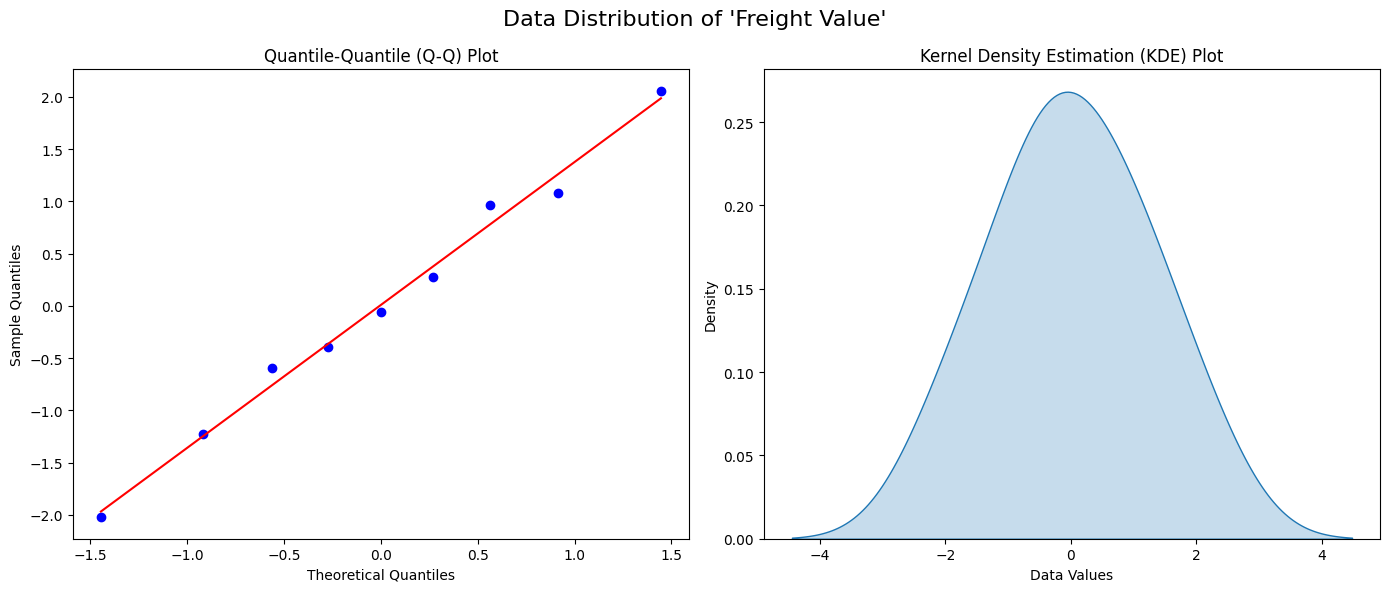

In [35]:
plt.figure(figsize=(14, 6))
plt.suptitle("Data Distribution of 'Freight Value'", fontsize=16)

# Create Q-Q plot
plt.subplot(1, 2, 1)
stats.probplot(q_scaled_data[5], dist="norm", plot=plt)
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Create KDE plot
plt.subplot(1, 2, 2)
sns.kdeplot(q_scaled_data[5], fill=True)
plt.title('Kernel Density Estimation (KDE) Plot')
plt.xlabel('Data Values')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Export Scaled and Transformed Data to CSV

In [48]:
# Create the directory if it does not exist
directory = 'Scaled Data'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the scaled dataframes to CSV files
pd.DataFrame(r_scaled_data, columns=df_freight_columndrop.columns).to_csv(os.path.join(directory, 'r_scaled_data.csv'), index=False)
pd.DataFrame(m_scaled_data, columns=df_freight_columndrop.columns).to_csv(os.path.join(directory, 'm_scaled_data.csv'), index=False)
pd.DataFrame(q_scaled_data, columns=df_freight_columndrop.columns).to_csv(os.path.join(directory, 'q_scaled_data.csv'), index=False)